<a href="https://colab.research.google.com/github/b4wolf/NEURALNETS/blob/main/model_lstm_12_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
from sklearn.impute import SimpleImputer

In [2]:
!pip install torch.geometric networkx torchvision

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import timedelta
import os
from google.colab import files
torch.manual_seed(1)
from torch.utils.data import DataLoader, TensorDataset
from torch_geometric.nn import GCNConv

# Ignore everything above

In [4]:
"""def impute_data(raw_data_path, year):
  df = pd.read_parquet(raw_data_path)
  df_filtered = df[df['valid'].dt.year.isin([2021, 2021])]
  df = pd.DataFrame(df_filtered)
  df = df.set_index('valid')
  df.index = df.index.floor('H')

  start_date = pd.to_datetime(f'{year}-01-01').floor('D')
  end_date = pd.to_datetime(f'{year+1}-01-01').floor('D') - timedelta(hours=1)
  complete_index = pd.date_range(start=start_date, end=end_date, freq='1H')
  complete_df = pd.DataFrame(index=complete_index)

  merged_df = complete_df.merge(df, left_index=True, right_index=True, how='left')
  merged_df = merged_df[~merged_df.index.duplicated(keep='first')]
  imputed_df = merged_df.fillna(method='ffill')
  return imputed_df

for filename in os.listdir('./raw_WI_data'):
    if '.parquet' not in filename:
      continue
    dataframe = impute_data('./raw_WI_data/' + filename, 2021)
    if len(dataframe) == 8760:
      file = dataframe.to_csv(f'./clean_WI_data/{filename[:3]}.csv')
"""

"def impute_data(raw_data_path, year):\n  df = pd.read_parquet(raw_data_path)\n  df_filtered = df[df['valid'].dt.year.isin([2021, 2021])]\n  df = pd.DataFrame(df_filtered)\n  df = df.set_index('valid')\n  df.index = df.index.floor('H')\n\n  start_date = pd.to_datetime(f'{year}-01-01').floor('D')\n  end_date = pd.to_datetime(f'{year+1}-01-01').floor('D') - timedelta(hours=1)\n  complete_index = pd.date_range(start=start_date, end=end_date, freq='1H')\n  complete_df = pd.DataFrame(index=complete_index)\n\n  merged_df = complete_df.merge(df, left_index=True, right_index=True, how='left')\n  merged_df = merged_df[~merged_df.index.duplicated(keep='first')]\n  imputed_df = merged_df.fillna(method='ffill')\n  return imputed_df\n\nfor filename in os.listdir('./raw_WI_data'):\n    if '.parquet' not in filename:\n      continue\n    dataframe = impute_data('./raw_WI_data/' + filename, 2021)\n    if len(dataframe) == 8760:\n      file = dataframe.to_csv(f'./clean_WI_data/{filename[:3]}.csv')\n"

In [5]:
station_data = []
for filename in os.listdir('.'):
  if '.csv' in filename:
    pm25_df = pd.read_csv(filename)
    station_data.append(np.array(pm25_df["Value"].values).reshape(-1, 1))

In [6]:
# from https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/
# Creates a series of lookback windows to be used for training and predicting window t+1
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return np.array(X), np.array(y)

In [7]:
normalized_station_data = []
for stat in station_data:
  train_size = int(len(stat) * 0.70)
  test_size = len(stat) - train_size

  #stat = stat.astype('float32')
  stat_train, stat_test = stat[:train_size], stat[train_size:]
  #scaler = preprocessing.StandardScaler().fit(stat_train)
  #stat_train = scaler.transform(stat_train)
  #stat_test = scaler.transform(stat_test)

  normalized_station_data.append([stat_train, stat_test])

print(len(normalized_station_data))

11


In [8]:
lookback = 7
station_train_dataset = []
station_test_dataset = []
for stat in normalized_station_data:
  X_train, y_train = create_dataset(stat[0], lookback=lookback)
  X_test, y_test = create_dataset(stat[1], lookback=lookback)
  station_train_dataset.append([X_train, y_train])
  station_test_dataset.append([X_test, y_test])

In [9]:
class LSTM_Model(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=100, num_layers=1, batch_first=True)
        self.linear = nn.Linear(in_features=100, out_features=input_size)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [10]:
def plot(model, timeseries, train_size, X_train, y_train, X_test, y_test):
  with torch.no_grad():
      # shift train predictions for plotting
      train_plot = np.ones_like(timeseries[:,0]) * np.nan
      y_pred = model(X_train)
      y_pred = y_pred[:, -1, 0]
      train_plot[lookback:train_size] = y_pred
      # shift test predictions for plotting
      y_pred = model(X_test)
      y_pred = y_pred[:, -1, 0]
      test_plot = np.ones_like(timeseries[:,0]) * np.nan
      test_plot[train_size+lookback:len(timeseries[:,0])] = y_pred
  # plot
  plt.plot(timeseries[:,0], c='b')
  plt.show()
  plt.plot(train_plot, c='r')
  plt.plot(test_plot, c='g')
  #plt.xlim(7250, 7750)
  plt.show()

In [11]:
# plt.title("PM 2.5 RMSE Loss Per Epoch")
# plt.plot(pm25_losses, label="pm25 loss")
# plt.show()

<ipython-input-12-1ed81aaf4c45>:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(X), torch.tensor(y)


Epoch 0: train RMSE 3.9289, test RMSE 3.0530
Epoch 1: train RMSE 3.1081, test RMSE 2.6896
Epoch 2: train RMSE 2.8109, test RMSE 2.6184
torch.Size([6125, 1])



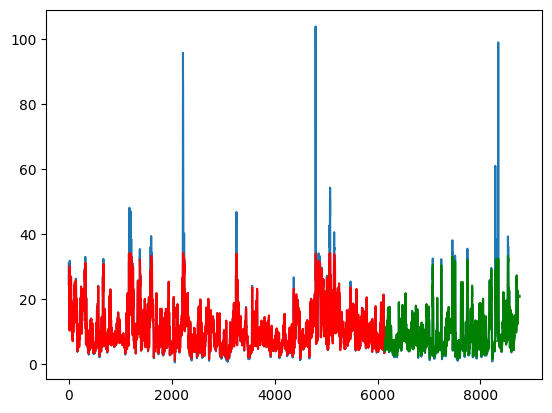

Epoch 0: train RMSE 3.2859, test RMSE 1.9890
Epoch 1: train RMSE 2.4550, test RMSE 1.8416
Epoch 2: train RMSE 2.1911, test RMSE 1.8567
torch.Size([6125, 1])



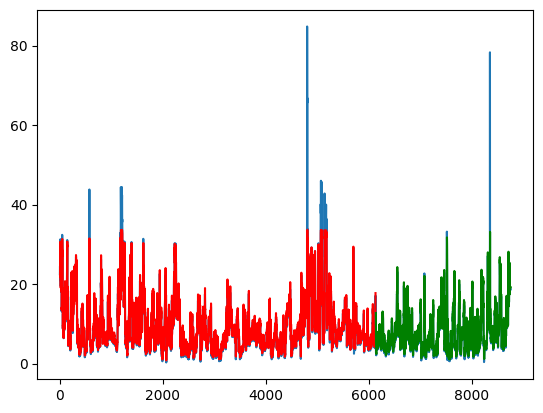

Epoch 0: train RMSE 3.8372, test RMSE 3.0370
Epoch 1: train RMSE 2.8560, test RMSE 2.5934
Epoch 2: train RMSE 2.4962, test RMSE 2.5018
torch.Size([6125, 1])



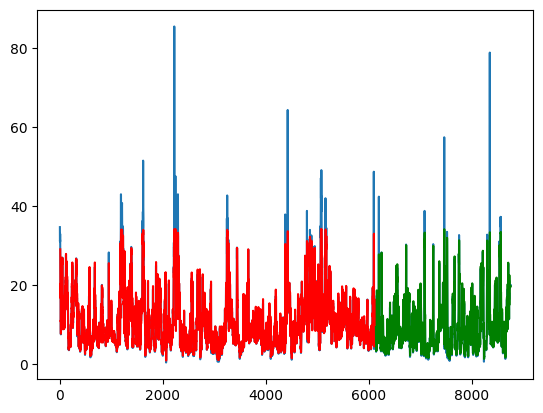

Epoch 0: train RMSE 2.9953, test RMSE 1.9681
Epoch 1: train RMSE 2.1657, test RMSE 1.7893
Epoch 2: train RMSE 1.8856, test RMSE 1.7172
torch.Size([6125, 1])



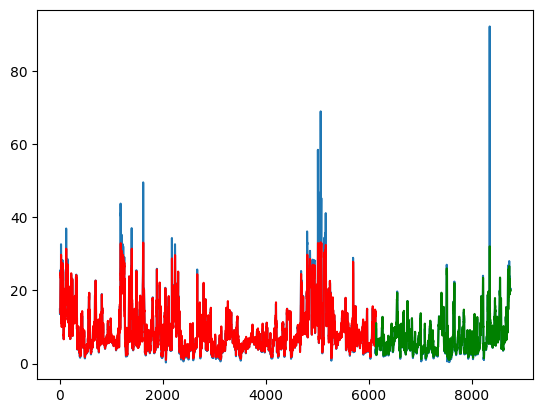

Epoch 0: train RMSE 3.1188, test RMSE 2.5143
Epoch 1: train RMSE 2.2340, test RMSE 2.2339
Epoch 2: train RMSE 1.9062, test RMSE 2.2009
torch.Size([6125, 1])



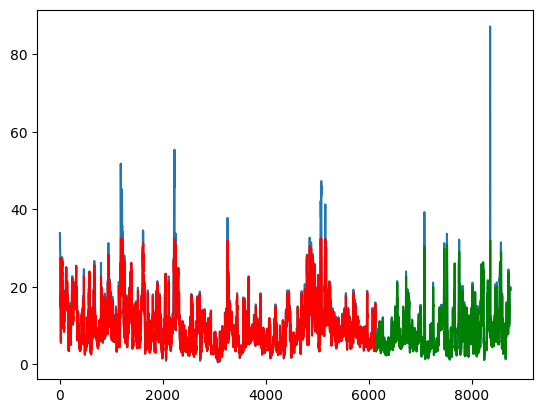

Epoch 0: train RMSE 5.7777, test RMSE 2.3003
Epoch 1: train RMSE 4.9299, test RMSE 2.1026
Epoch 2: train RMSE 4.4486, test RMSE 1.9876
torch.Size([6125, 1])



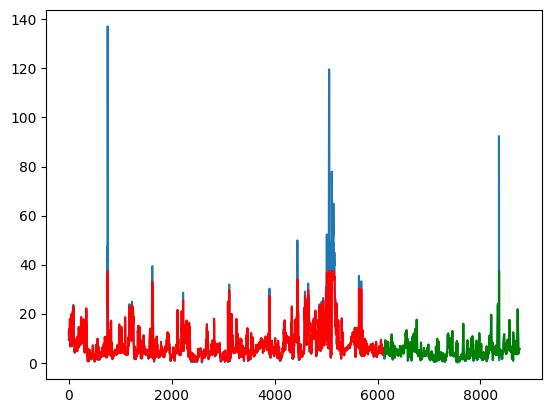

Epoch 0: train RMSE 2.6229, test RMSE 1.6106
Epoch 1: train RMSE 1.9978, test RMSE 1.5609
Epoch 2: train RMSE 1.7503, test RMSE 1.5614
torch.Size([6125, 1])



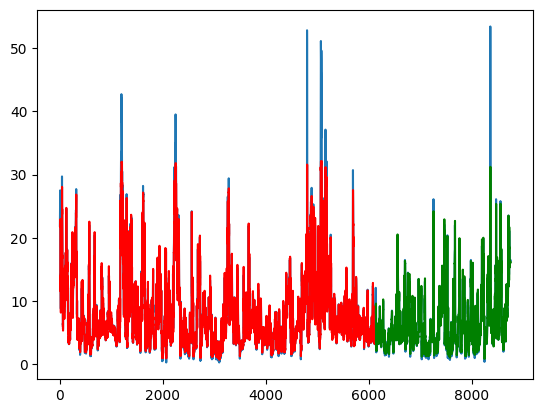

Epoch 0: train RMSE 5.4426, test RMSE 1.5338
Epoch 1: train RMSE 4.6408, test RMSE 1.3747
Epoch 2: train RMSE 4.2621, test RMSE 1.4323
torch.Size([6125, 1])



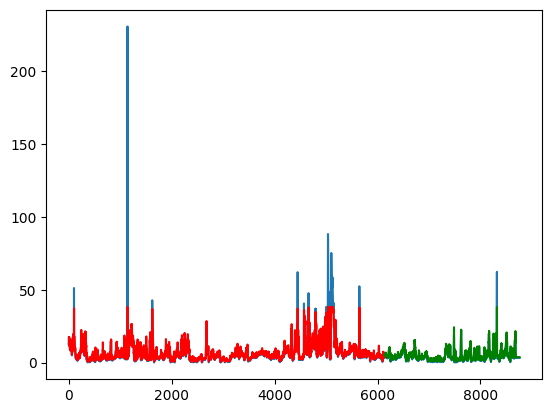

Epoch 0: train RMSE 3.9735, test RMSE 1.9324
Epoch 1: train RMSE 3.1042, test RMSE 1.8535
Epoch 2: train RMSE 2.6942, test RMSE 1.8260
torch.Size([6125, 1])



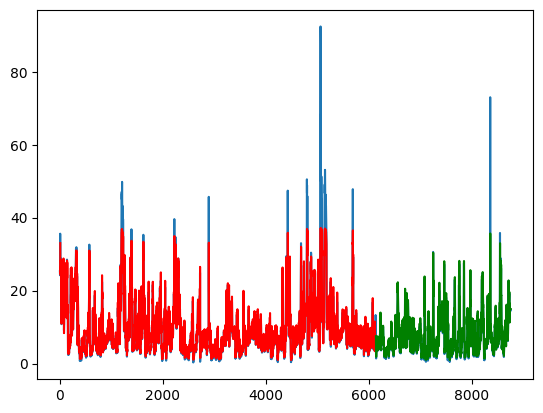

Epoch 0: train RMSE 4.4810, test RMSE 2.3660
Epoch 1: train RMSE 3.4475, test RMSE 2.1445
Epoch 2: train RMSE 2.9105, test RMSE 2.0881
torch.Size([6125, 1])



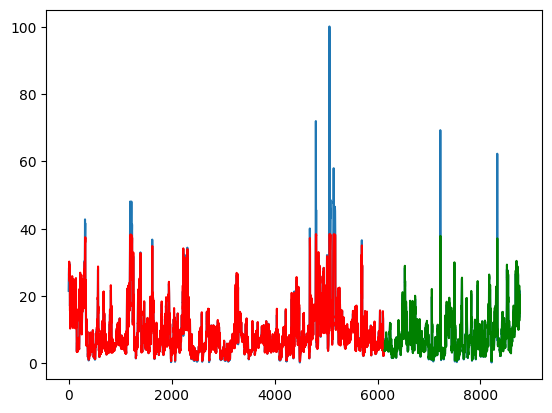

Epoch 0: train RMSE 3.2876, test RMSE 2.6350
Epoch 1: train RMSE 2.4707, test RMSE 2.4142
Epoch 2: train RMSE 2.1855, test RMSE 2.3278
torch.Size([6125, 1])



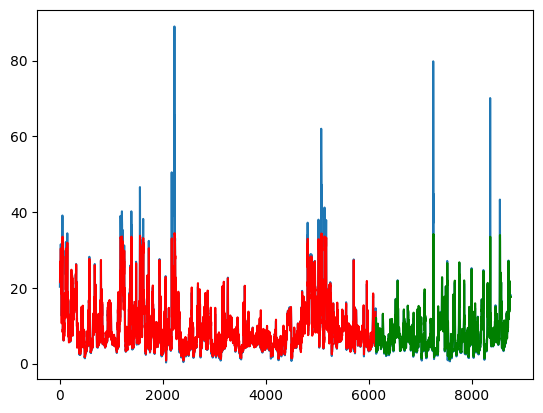

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

station_data = []
for filename in os.listdir('.'):
  if '.csv' in filename:
    df = pd.read_csv(filename)
    timeseries = df[["Value"]].values.astype('float32')
    station_data.append(timeseries)

stat_train_predictions = []
stat_test_predictions = []
#timeseries[7760:k]
# train-test split for time series
for timeseries in station_data:
  train_size = int(len(timeseries) * 0.70)
  test_size = len(timeseries) - train_size
  train, test = timeseries[:train_size], timeseries[train_size:]

  def create_dataset(dataset, lookback):
      """Transform a time series into a prediction dataset

      Args:
          dataset: A numpy array of time series, first dimension is the time steps
          lookback: Size of window for prediction
      """
      X, y = [], []
      for i in range(len(dataset)-lookback):
          feature = dataset[i:i+lookback]
          target = dataset[i+1:i+lookback+1]
          X.append(feature)
          y.append(target)
      return torch.tensor(X), torch.tensor(y)

  lookback = 7
  X_train, y_train = create_dataset(train, lookback=lookback)
  X_test, y_test = create_dataset(test, lookback=lookback)
  class AirModel(nn.Module):
      def __init__(self):
          super().__init__()
          self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
          self.linear = nn.Linear(50, 1)
      def forward(self, x):
          x, _ = self.lstm(x)
          x = self.linear(x)
          return x

  model = AirModel()
  optimizer = optim.Adam(model.parameters())
  loss_fn = nn.MSELoss()
  loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

  n_epochs = 3
  for epoch in range(n_epochs):
      model.train()
      losses = []
      for X_batch, y_batch in loader:
          y_pred = model(X_batch)
          loss = loss_fn(y_pred, y_batch)
          losses.append(loss.detach().numpy())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      # Validation
      model.eval()
      with torch.no_grad():
          y_pred = model(X_train)
          train_rmse = np.sqrt(loss_fn(y_pred, y_train))
          y_pred = model(X_test)
          test_rmse = np.sqrt(loss_fn(y_pred, y_test))
      print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

  with torch.no_grad():
      # shift train predictions for plotting
      train_plot = np.ones_like(timeseries) * np.nan
      y_pred = model(X_train)
      stat_train_predictions.append(y_pred[: -1, :])

      y_pred = y_pred[:, -1, :]
      print(y_pred.shape)
      train_plot[lookback:train_size] = model(X_train)[:, -1, :]
      # shift test predictions for plotting
      test_plot = np.ones_like(timeseries) * np.nan
      y_pred = model(X_test)
      stat_test_predictions.append(y_pred[:, -1, :])
      print()
      test_plot[train_size+lookback:len(timeseries)] = y_pred[:, -1, :]
  # plot
  plt.plot(timeseries)
  plt.plot(train_plot, c='r')
  plt.plot(test_plot, c='g')
  plt.show()

In [13]:
stat_train_predictions[0].shape

torch.Size([6124, 7, 1])

# Try try again, closer version

note that the files for processed monitor are stored in content when on colab but might be different when local

In [14]:
import torch
import folium
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from scipy.spatial.distance import euclidean
import os
import networkx as nx
from torch_geometric.data import Data
import math
from heapq import nsmallest
import pandas as pd
import re
import glob
import matplotlib.pyplot as plt

In [15]:
directory_path = '/content/'
file_names = [file for file in os.listdir(directory_path) if 'monitor' in file and file.endswith('.csv')]
data_frames = []

for file_name in file_names:
    match = re.match(r'processed_monitor_([0-9.-]+)_([0-9.-]+)\.csv', file_name)
    if match:
        lat, lon = match.groups()
        lat, lon = float(lat), float(lon)
        try:
            df = pd.read_csv(os.path.join(directory_path, file_name))
            df['Latitude'] = lat
            df['Longitude'] = lon
            data_frames.append(df)
        except FileNotFoundError:
            print(f"File not found: {file_name}")
        except pd.errors.EmptyDataError:
            print(f"No data in file: {file_name}")
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")
    else:
        print(f"Filename pattern mismatch: {file_name}")

In [16]:
directory_path = '/content/'
file_names = glob.glob(os.path.join(directory_path, '*.csv'))

In [17]:
nodes = list(range(len(data_frames)))

In [18]:
def haversine(coord1, coord2):
    R = 6371.0
    lat1, lon1 = math.radians(coord1[0]), math.radians(coord1[1])
    lat2, lon2 = math.radians(coord2[0]), math.radians(coord2[1])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

G = nx.Graph()

distances = {}
for i in range(len(data_frames)):
    distances[i] = []
    coord1 = (data_frames[i]['Latitude'].iloc[0], data_frames[i]['Longitude'].iloc[0])
    for j in range(len(data_frames)):
        if i != j:
            coord2 = (data_frames[j]['Latitude'].iloc[0], data_frames[j]['Longitude'].iloc[0])
            distance = haversine(coord1, coord2)
            distances[i].append((distance, j))

for i, dist_list in distances.items():
    three_nearest = nsmallest(3, dist_list)
    for dist, j in three_nearest:
        G.add_edge(i, j, weight=dist)


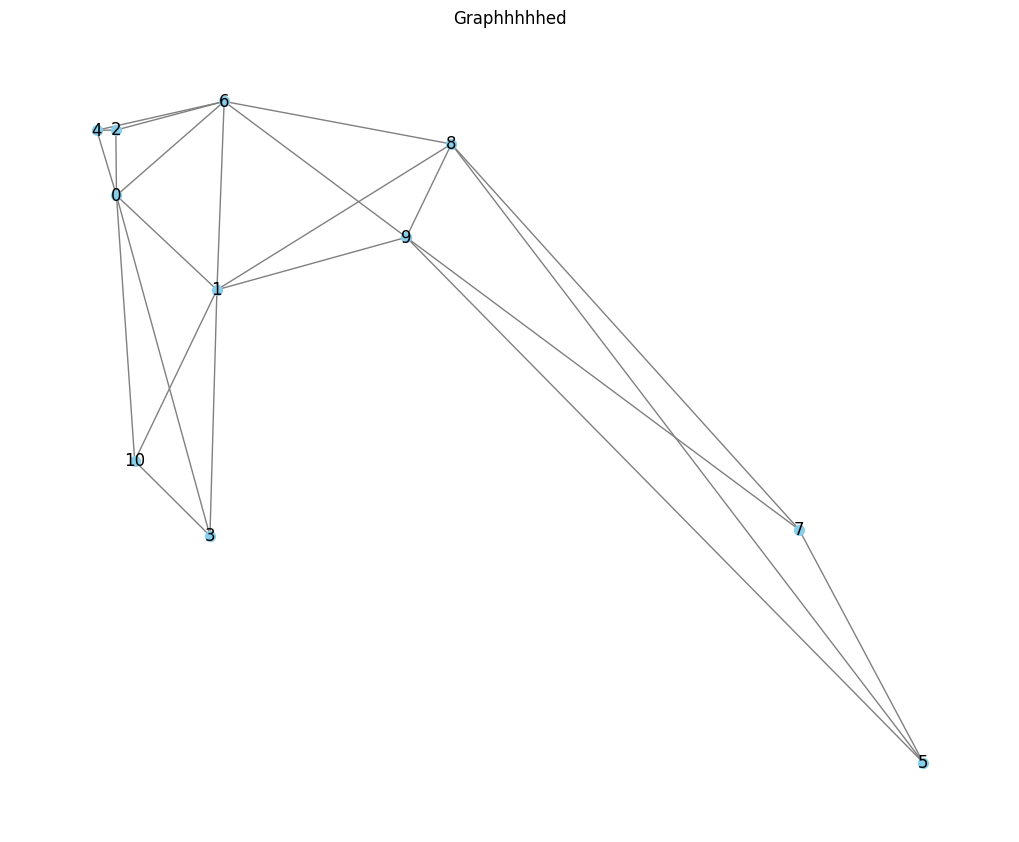

In [19]:
G = nx.Graph()
distances = {}
node_positions = {}

for i in range(len(data_frames)):
    coord1 = (data_frames[i]['Latitude'].iloc[0], data_frames[i]['Longitude'].iloc[0])
    node_positions[i] = coord1
    distances[i] = []

    for j in range(len(data_frames)):
        if i != j:
            coord2 = (data_frames[j]['Latitude'].iloc[0], data_frames[j]['Longitude'].iloc[0])
            distance = haversine(coord1, coord2)
            distances[i].append((distance, j))

for i, dist_list in distances.items():
    three_nearest = nsmallest(3, dist_list)
    for dist, j in three_nearest:
        G.add_edge(i, j, weight=dist)

plt.figure(figsize=(10, 8))
nx.draw(G, pos=node_positions, with_labels=True, node_size=50, node_color="skyblue", edge_color="gray")
plt.title("Graphhhhhed")
plt.show()


In [20]:
directory_path = '/content/'
pattern = re.compile(r'([0-9.-]+)_([0-9.-]+)\.csv')
lat_lon_pairs = []
for file_name in os.listdir(directory_path):
    if file_name.endswith('.csv'):
        match = pattern.search(file_name)
        if match:
            lat, lon = match.groups()
            lat_lon_pairs.append((float(lat), float(lon)))
print(lat_lon_pairs)

[(43.020075, -88.21507), (43.46611, -88.62111), (43.01724, -87.93369), (43.4351, -89.67979), (42.93257, -87.93434), (46.60234, -90.65615), (43.4983, -87.8102), (46.0519, -89.654), (44.50729, -87.99344), (44.30738, -88.39509), (43.10101, -89.35768)]


In [21]:
wisconsin_center = (44.5000, -89.5000)
map_wisconsin = folium.Map(location=wisconsin_center, zoom_start=7)
lat_lon_list = lat_lon_pairs

for lat, lon in lat_lon_list:
    folium.Marker(location=(lat, lon)).add_to(map_wisconsin)

In [22]:
example_tensor = stat_train_predictions[0]

In [23]:
example_tensor[0].shape

torch.Size([7, 1])

# Training Tensors and Testing tensor dataframes

In [91]:
columns = {}
for i, tensor in enumerate(stat_train_predictions):
    if isinstance(tensor, torch.Tensor) and tensor.shape == (6124, 7, 1):
        column = tensor[:, 6, :].squeeze()
        columns[f"{i+1}"] = column.numpy()
    else:
        raise ValueError(f"Item {i} in stat_train_predictions is not a tensor with shape [6124, 7, 1]")

df_tensor_11_train = pd.DataFrame(columns)

In [92]:
df_tensor_11_train

,1,2,3,4,5,6,7,8,9,10,11
0,29.019121,27.303034,29.087505,13.916239,27.454582,9.398474,21.727659,17.546690,33.010582,26.473848,24.408894
1,28.280745,21.829590,27.364483,16.786280,27.472412,9.668251,22.926842,16.552883,25.723833,28.461611,26.946373
2,26.782932,26.168978,18.427017,21.316277,20.091351,9.342310,20.786274,16.899935,29.897528,25.731016,21.378124
3,23.680216,28.800346,16.798559,22.750576,14.857225,10.386398,13.087262,16.867363,26.050291,25.320000,25.818150
4,18.436325,30.707981,20.407949,21.640129,18.226154,12.275423,14.267604,17.286428,26.387175,30.256838,21.483768
...,...,...,...,...,...,...,...,...,...,...,...
6119,9.843253,6.208017,13.416340,12.793804,11.274654,3.378241,3.726383,3.536197,4.248554,5.795973,6.219464
6120,11.099544,7.866158,15.816686,13.985371,11.776613,5.844350,3.716767,3.884321,3.886081,6.206381,6.783931
6121,8.046129,8.001624,12.736637,13.456868,15.647961,4.011546,3.819442,3.651245,3.815091,6.230101,8.035644
6122,8.917481,10.700531,15.296234,14.331275,15.114250,4.142968,9.185575,3.831049,3.819918,6.298188,9.486584


In [93]:
# df_tensor_11_train = pd.DataFrame(torch.cat(tuple(stat_train_predictions), axis=1).numpy())
df_tensor_11_test = pd.DataFrame(torch.cat(tuple(stat_test_predictions), axis=1).numpy())
df_tensor_11_test

,0,1,2,3,4,5,6,7,8,9,10
0,3.917360,12.735870,9.435043,2.769185,7.580180,6.268938,8.203256,4.806314,7.514414,3.708991,10.302220
1,4.124944,4.358547,7.254518,3.297309,5.349312,4.598284,9.606668,4.689807,3.236368,4.156784,10.433049
2,4.431075,3.363006,9.279624,3.695292,3.338468,4.676782,7.632179,5.351508,2.895103,3.864201,12.068767
3,5.032074,3.668543,4.911616,4.196315,3.792689,2.661460,8.768825,5.900565,2.822244,4.047019,9.592057
4,5.426843,2.633172,3.833982,11.072616,4.808681,2.988722,5.807165,5.597110,2.640304,4.384148,7.912929
...,...,...,...,...,...,...,...,...,...,...,...
2616,20.608860,19.186804,19.730700,19.981537,19.299852,5.685124,16.131348,3.792055,14.942100,13.179193,17.614708
2617,20.608860,19.186804,19.730700,19.981537,19.299852,5.685124,16.131348,3.792055,14.942100,15.578967,17.614708
2618,20.608860,19.186804,19.730700,19.981537,19.299852,5.685124,16.131348,3.792055,14.942100,16.670439,17.614708
2619,20.608860,19.186804,19.730700,19.981537,19.299852,5.685124,16.131348,3.792055,14.942100,15.061982,17.614708


In [94]:
print(len(df_tensor_11_test))
print(len(df_tensor_11_train))

2621
6124


In [95]:
targets = torch.tensor([df[['Value']].values for df in data_frames], dtype=torch.float)

In [96]:
targets.shape

torch.Size([11, 8760, 1])

In [103]:
df_tensor_11_test.columns = df_tensor_11_test.columns.astype(str)
df_tensor_11_test.columns = [str(int(col)+1) for col in df_tensor_11_test.columns]
combined_df = pd.concat([df_tensor_11_train, df_tensor_11_test], axis=0, ignore_index=True)
combined_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,29.019121,27.303034,29.087505,13.916239,27.454582,9.398474,21.727659,17.546690,33.010582,26.473848,24.408894,NaN,NaN
1,28.280745,21.829590,27.364483,16.786280,27.472412,9.668251,22.926842,16.552883,25.723833,28.461611,26.946373,NaN,NaN
2,26.782932,26.168978,18.427017,21.316277,20.091351,9.342310,20.786274,16.899935,29.897528,25.731016,21.378124,NaN,NaN
3,23.680216,28.800346,16.798559,22.750576,14.857225,10.386398,13.087262,16.867363,26.050291,25.320000,25.818150,NaN,NaN
4,18.436325,30.707981,20.407949,21.640129,18.226154,12.275423,14.267604,17.286428,26.387175,30.256838,21.483768,NaN,NaN


In [104]:
edge_index = torch.tensor(list(G.edges())).t().contiguous()

# change x to have stat train and test predictions
x = torch.tensor([[combined_df[col].values()] for col in combined_df], dtype=torch.float)

# this one is the targets, which I think is right rn
targets = torch.tensor([df[['Value']].values for df in data_frames], dtype=torch.float)
data = Data(x=x, edge_index=edge_index, y=targets)
num_nodes = data.num_nodes
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_size = int(num_nodes * 0.8)
train_mask[:train_size] = True
test_mask[train_size:] = True
data.train_mask = train_mask
data.test_mask = test_mask

class BasicGNN(torch.nn.Module):
    def __init__(self, num_features):
        super(BasicGNN, self).__init__()
        self.conv1 = SAGEConv(num_features, 16)
        self.conv2 = SAGEConv(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x.squeeze()

model = BasicGNN(num_features=2)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

for epoch in range(2000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

TypeError: ignored

In [ ]:
model.eval()
with torch.no_grad():
    pred = model(data).squeeze()
    test_pred = pred[data.test_mask]
    test_targets = data.y[data.test_mask]
    mse = torch.mean((test_pred - test_targets) ** 2)
    print(f'Mean Squared Error (MSE): {mse.item()}')
    rmse = torch.sqrt(mse)
    print(f'Root Mean Squared Error (RMSE): {rmse.item()}')
    target_mean = test_targets.mean()
    total_variance = torch.sum((test_targets - target_mean) ** 2)
    residual_variance = torch.sum((test_targets - test_pred) ** 2)
    r2_score = 1 - (residual_variance / total_variance)
    print(f'R² Score: {r2_score.item()}')

In [37]:

x = torch.tensor([[df_tensor_11_train[col].mean(), df_tensor_11_test[col].mean()] for col in df_tensor_11_train.columns], dtype=torch.float)

# Assuming the targets are correctly set up
# Ensure that targets are a 1D tensor of the correct shape
targets = torch.tensor([val for df in data_frames for val in df['Value'].values], dtype=torch.float)

# Rest of your code for setting up the graph data, train/test masks, and GNN model
edge_index = torch.tensor(list(G.edges())).t().contiguous()
data = Data(x=x, edge_index=edge_index, y=targets)

num_nodes = data.num_nodes
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_size = int(num_nodes * 0.8)
train_mask[:train_size] = True
test_mask[train_size:] = True

data.train_mask = train_mask
data.test_mask = test_mask



IndexError: ignored

# might be useful idk (Graveyard coded)

In [ ]:
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.CrossEntropyLoss()

# for epoch in range(50):
#     model.train()
#     optimizer.zero_grad()
#     out = model(data)
#     loss = criterion(out[data.train_mask], data.y[data.train_mask])
#     loss.backward()
#     optimizer.step()
#     print(f'Epoch {epoch}, Loss: {loss.item()}')


In [ ]:
# edge_index = torch.tensor(list(G.edges)).t().contiguous()
# # stensor = tensor([[ 0,  0,  0,  0,  0,  0,  0,  7,  7,  7,  8,  8,  8,  8, 11, 11, 11,  1,1, 14,  2,  3,  3, 16, 16,  4,  4,  4,  9,  9,  9,  5,  5, 13,  6],[ 7,  8, 11,  1,  3, 14, 16,  2, 15,  8,  1,  2, 15, 14,  3, 10, 16, 14,4,  4, 15, 16, 10,  6, 10,  9,  5, 12,  5, 12, 13, 13, 12,  6, 10]])
# x = torch.tensor([[df['Value'].mean(), df['Value'].std()] for df in data_frames], dtype=torch.float)
data = Data(x=x, edge_index=edge_index)
# data = Data(x=[17, 2], edge_index=[2, 35])
num_features = 2
num_classes = 8760

# regression_targets = torch.tensor([df[['Value']].values for df in data_frames], dtype=torch.float)
# targets_tensor = torch.tensor(regression_targets, dtype=torch.float)
# data = Data(edge_index=edge_index, x=node_features)
# data.y = targets_tensor
# print(f'this is the true data {len(targets_tensor)}')
# # this is the true data 17
# print(data.shape)
# print(data.edge_index)

In [ ]:
# num_nodes = data.num_nodes
# train_size = int(num_nodes * 0.8)

# train_mask = torch.zeros(num_nodes, dtype=torch.bool)
# train_mask[:train_size] = True

# num_features = 2
# num_classes = 8760


# data.train_mask = train_mask
# data.y = targets_tensor.view(-1)


# class BasicGNN(torch.nn.Module):
#     def __init__(self, num_features):
#         super(BasicGNN, self).__init__()
#         self.conv1 = SAGEConv(num_features, 16)
#         self.conv2 = SAGEConv(16, 1)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         x = F.relu(self.conv1(x, edge_index))
#         x = F.dropout(x, training=self.training)
#         x = self.conv2(x, edge_index)
#         return x.squeeze()


# model = BasicGNN(num_features)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.MSELoss()

# # Training loop
# for epoch in range(50):
#     model.train()
#     optimizer.zero_grad()
#     out = model(data)
#     # Reshape out if necessary
#     out = out.view_as(data.y)

#     # Check shapes
#     assert out.shape[0] == data.num_nodes, "Output size does not match number of nodes"

#     # Compute loss
#     loss = criterion(out[data.train_mask], data.y[data.train_mask])
#     loss.backward()
#     optimizer.step()
#     print(f'Epoch {epoch}, Loss: {loss.item()}')

In [ ]:
# edge_index = torch.tensor(list(G.edges)).t().contiguous()

# x = torch.tensor([[df['Value'].mean(), df['Value'].std()] for df in data_frames], dtype=torch.float)
# regression_targets = torch.tensor([df[['Value']].values for df in data_frames], dtype=torch.float)
# targets_tensor = torch.tensor([df[['Value']].values for df in data_frames], dtype=torch.float)
# targets_tensor = targets_tensor.view(-1)
# targets = [df['Value'].mean() for df in data_frames]
# data = Data(x=x, edge_index=edge_index, y=targets_tensor)
# num_nodes = data.num_nodes
# test_mask = torch.zeros(num_nodes, dtype=torch.bool)
# test_mask[int(0.8 * num_nodes):] = True  # Assuming the last 20% of the data is for testing
# data.test_mask = test_mask

# data.y = torch.tensor(targets, dtype=torch.float)
# num_nodes = data.num_nodes  # Total number of nodes in your graph

# num_nodes = data.num_nodes
# train_size = int(num_nodes * 0.8)

# train_mask = torch.zeros(num_nodes, dtype=torch.bool)
# train_mask[:train_size] = True
# edge_index = torch.tensor(list(G.edges)).t().contiguous()
# x = torch.tensor([[df['Value'].mean(), df['Value'].std()] for df in data_frames], dtype=torch.float)
# targets = [df['Value'].mean() for df in data_frames]
# data = Data(x=x, edge_index=edge_index, y=torch.tensor(targets, dtype=torch.float))
# data.train_mask = train_mask
# num_nodes = data.num_nodes
# train_size = int(num_nodes * 0.8)

# train_mask = torch.zeros(num_nodes, dtype=torch.bool)
# train_mask[:train_size] = True

# num_features = 2

# class BasicGNN(torch.nn.Module):
#     def __init__(self, num_features):
#         super(BasicGNN, self).__init__()
#         self.conv1 = SAGEConv(num_features, 16)
#         self.conv2 = SAGEConv(16, 1)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         x = F.relu(self.conv1(x, edge_index))
#         x = F.dropout(x, training=self.training)
#         x = self.conv2(x, edge_index)
#         return x.squeeze()

# model = BasicGNN(num_features)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.MSELoss()

# # Training loop
# for epoch in range(20000):
#     model.train()
#     optimizer.zero_grad()
#     out = model(data)
#     out = out.view_as(data.y)
#     assert out.shape[0] == data.num_nodes, "Output size does not match number of nodes"
#     loss = criterion(out[data.train_mask], data.y[data.train_mask])
#     loss.backward()
#     optimizer.step()
#     #print(f'Epoch {epoch}, Loss: {loss.item()}')


In [ ]:
# import torch.optim as optim
# import torch.utils.data as data

# def r2_score(predicted, target):
#     mean_target = torch.mean(target)
#     total_variance = torch.sum((target - mean_target)**2)
#     residual_variance = torch.sum((target - predicted)**2)
#     r_squared = 1 - (residual_variance / total_variance)

#     return r_squared.item()

# for i in range(len(station_data)):
#   X_train = torch.tensor(station_train_dataset[i][0], dtype=torch.float)
#   y_train = torch.tensor(station_train_dataset[i][1], dtype=torch.float)
#   X_test = torch.tensor(station_test_dataset[i][0], dtype=torch.float)
#   y_test = torch.tensor(station_test_dataset[i][1], dtype=torch.float)

#   loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
#   n_epochs = 100
#   loss_fn = nn.MSELoss()
#   input_size = 1
#   stat_train_predictions = []
#   stat_test_predictions = []
#   def models(loader, X_train, y_train, X_test, y_test):
#     model = LSTM_Model(input_size)
#     optimizer = optim.Adam(model.parameters(), lr=0.01)
#     losses = []
#     for epoch in range(n_epochs):
#         model.train()
#         avg_loss = []
#         for X_batch, y_batch in loader:
#             y_pred = model(X_batch)
#             loss = loss_fn(y_pred, y_batch)
#             avg_loss.append(loss.detach().numpy())
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#         losses.append(np.mean(avg_loss))
#         # Validation
#         model.eval()
#         with torch.no_grad():
#             y_pred = model(X_train)
#             stat_train_predictions.append(y_pred)
#             train_rmse = np.sqrt(loss_fn(y_pred, y_train))
#             r2_score_train = r2_score(y_pred, y_train)
#             y_pred = model(X_test)
#             stat_test_predictions.append(y_pred)
#             test_rmse = np.sqrt(loss_fn(y_pred, y_test))
#             r2_score_test = r2_score(y_pred, y_test)

#         print("Epoch %d: train RMSE %.4f, test RMSE %.4f, train R2 %.4f, test R2 %.4f" % (epoch, train_rmse, test_rmse, r2_score_train, r2_score_test))
#     return model, losses

#   print("PM 2.5 Model")
#   pm25_model, pm25_losses = models(loader, X_train, y_train, X_test, y_test)
#   plot(pm25_model, station_data[0], train_size, X_train, y_train, X_test, y_test)